###############################################################################
# Jupyter Notebook: Analysis of A Comparative Analysis of Student Loan Default Rates Among Black Students in HBCUs and Non-HBCUs
###############################################################################

 -----------------------------------------------------------------------
 0. SUPPRESS WARNINGS AND SETUP
 -----------------------------------------------------------------------

In [346]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import re
plt.style.use('tableau-colorblind10')


# 1. INTRODUCTION

This notebook explores how loan default rates, repayment rates, and median debt
vary between Historically Black Colleges and Universities (HBCUs) and non-HBCUs.
We focus on Pell Grant recipients using four-year default and repayment rates.

Goals:
1. Examine whether Pell Grant recipients at HBCUs have different default 
   and repayment rates compared to those at non-HBCUs.
2. Investigate whether the median debt differs for Pell vs. non-Pell students
   between HBCUs and non-HBCUs.
3. Explore whether default and repayment rates are related to the amount borrowed,
   and whether this relationship differs by HBCU status.

# 2. LOAD AND CLEAN THE DATA

We begin by loading our dataset: 'Most-Recent-Cohorts-Institution.csv'.
Then we select relevant columns, convert columns to numeric where needed,
and clean default rate columns that may contain ranges or inequality signs.

-------------------------------
## 2.1 Load the dataset
-------------------------------

In [347]:
df = pd.read_csv("Most-Recent-Cohorts-Institution.csv")

-------------------------------
## 2.2 Make a copy of the original for reference
-------------------------------

In [348]:
df_original = df.copy()

-------------------------------
## 2.3 Define the columns we want
-------------------------------

In [349]:
COLUMNS = ['HBCU', 'INSTNM', 'BBRR4_FED_PELL_DFLT', 'BBRR4_FED_PELL_PAIDINFULL', 'PELL_DEBT_MDN', 'NOPELL_DEBT_MDN'] #overall columns
COLS_TO_BE_CLEANED = ['BBRR4_FED_PELL_DFLT', 'BBRR4_FED_PELL_PAIDINFULL'] #columns that need cleaning

In [350]:
df = df[COLUMNS] #only keep columns needed for analysis

In [351]:
# Convert 'PELL_DEBT_MDN' column to numeric
df['PELL_DEBT_MDN'] = pd.to_numeric(df['PELL_DEBT_MDN'], errors='coerce')

-------------------------------
# 2.4 Define a cleaning function
-------------------------------

In [352]:
def clean_bbr_value(x):
    """
    Cleans a default rate value:
      - For ranges (e.g.'0.10-0.14'), calculates the average.
      - For values with inequality symbols, removes the symbols and converts to float.
      - Returns None if the value is missing or cannot be converted.
    """
    if pd.isnull(x):
        return None
    s = str(x).strip()
    if s == '':
        return None
    
    # Handle range: "0.10-0.14"
    if '-' in s:
        parts = re.split(r'\s*-\s*', s)
        if len(parts) == 2:
            try:
                n1 = float(re.sub(r'[^\d\.]', '', parts[0]))
                n2 = float(re.sub(r'[^\d\.]', '', parts[1]))
                return (n1 + n2) / 2
            except Exception:
                return None
                
    # Remove inequality symbols (<=, >=, <, >) and any extraneous characters
    s = re.sub(r'(<=|>=|<|>)', '', s).strip()
    s = re.sub(r'[^\d\.]', '', s)
    try:
        return float(s)
    except Exception:
        return None



-------------------------------
## 2.5 Clean the Pell default and repayment columns
-------------------------------

In [353]:
#apply the cleaning function to columns that require cleaning
for col in COLS_TO_BE_CLEANED:
    df[col] = df[col].apply(clean_bbr_value)

-------------------------------
## 2.6 Rename and drop NaN rows
-------------------------------

In [354]:
df.rename(columns={'BBRR4_FED_PELL_DFLT': 'Default_Rate', 'BBRR4_FED_PELL_PAIDINFULL': 'Repayment_Rate'}, inplace=True)
df.dropna(inplace=True)

-------------------------------
## 2.7 Final DataFrames for each research question
-------------------------------

In [355]:
df_r1 = df.copy()  # For RQ1 (Default and Repayment with HBCU)
df_r2 = df.copy()  # For RQ2 (Median debt for Pell vs. non-Pell)
df_r3 = df.copy()  # For RQ3 (Relation between debt and default/repayment)

# 3. RESEARCH QUESTION 1

Research Question 1:
How does the loan default rate vary between Pell Grant students in HBCUs and 
non-HBCUs, or is it relatively the same across all universities?

Variables:
- Explanatory: University Type (HBCU vs. Non-HBCU)
- Outcome: Loan Default Rate (Default_Rate) and Loan Repayment Rate (Repayment_Rate)
  specifically for Pell Grant students.

-------------------------------
## 3.1 VISUALIZATIONS: Loan Default Rate and Repayment Rate by HBCU vs Non-HBCU for Pell Grant Recipents
-------------------------------

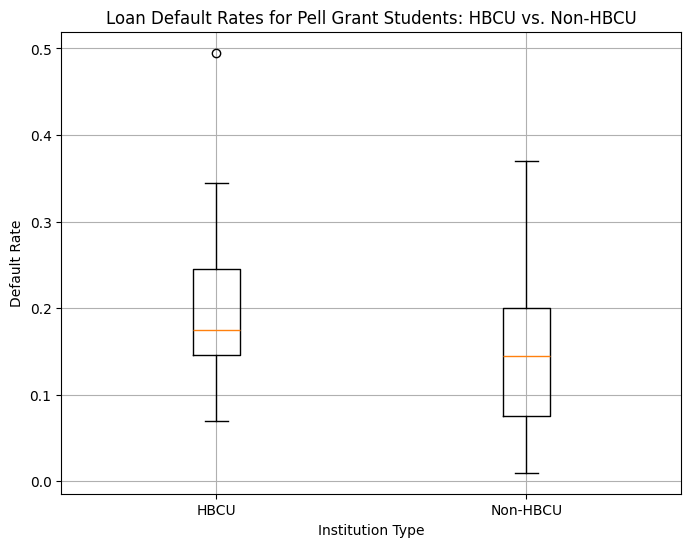

In [356]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell Grant default rates between HBCU and non-HBCU institutions.
hbcu_defaults = df_r1[df_r1['HBCU'] == 1]['Default_Rate']
non_hbcu_defaults = df_r1[df_r1['HBCU'] == 0]['Default_Rate']

ax.boxplot([hbcu_defaults, non_hbcu_defaults], labels=['HBCU', 'Non-HBCU'])
ax.set_title('Loan Default Rates for Pell Grant Students: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Default Rate')
ax.grid(True)
plt.show()

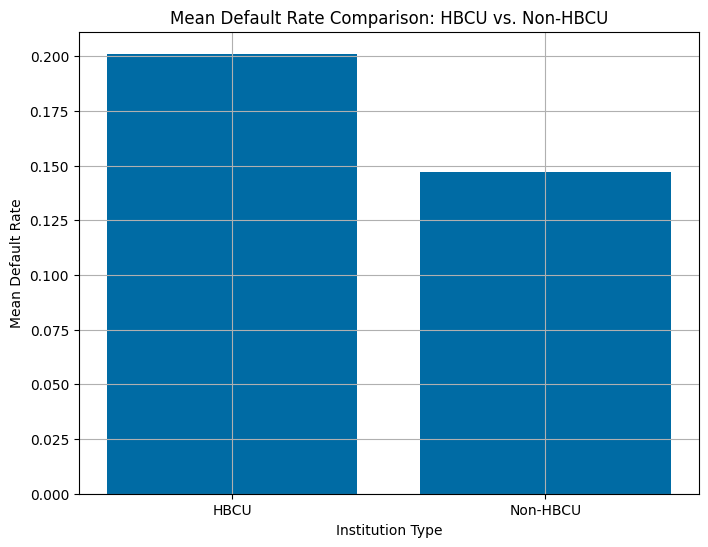

In [357]:
mean_hbcu_default = hbcu_defaults.mean()
mean_non_hbcu_default = non_hbcu_defaults.mean()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This bar chart compares the mean Pell Grant default rate for HBCU vs. Non-HBCU institutions.
ax.bar(['HBCU', 'Non-HBCU'], [mean_hbcu_default, mean_non_hbcu_default])
ax.set_title('Mean Default Rate Comparison: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Mean Default Rate')
ax.grid(True)
plt.show()


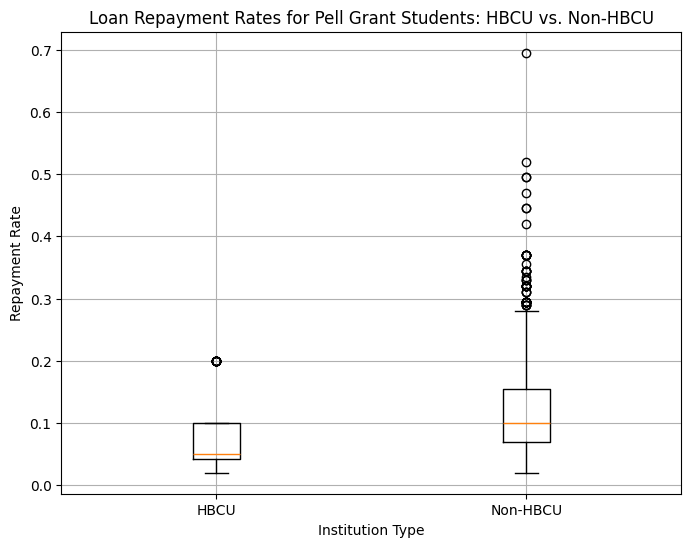

In [358]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell Grant repayment rates between HBCU and non-HBCU institutions.
hbcu_repayments = df_r1[df_r1['HBCU'] == 1]['Repayment_Rate']
non_hbcu_repayments = df_r1[df_r1['HBCU'] == 0]['Repayment_Rate']

ax.boxplot([hbcu_repayments, non_hbcu_repayments], labels=['HBCU', 'Non-HBCU'])
ax.set_title('Loan Repayment Rates for Pell Grant Students: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Repayment Rate')
ax.grid(True)
plt.show()

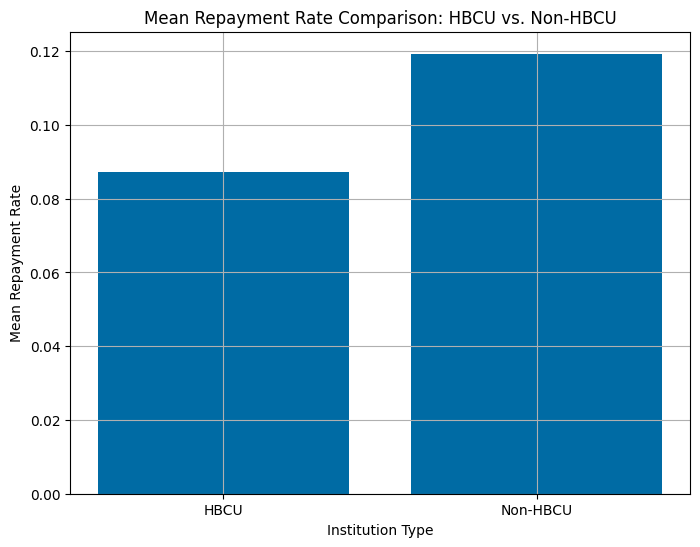

In [359]:
mean_hbcu_repay = hbcu_repayments.mean()
mean_non_hbcu_repay = non_hbcu_repayments.mean()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This bar chart compares the mean Pell Grant repayment rate for HBCU vs. Non-HBCU institutions.
ax.bar(['HBCU', 'Non-HBCU'], [mean_hbcu_repay, mean_non_hbcu_repay])
ax.set_title('Mean Repayment Rate Comparison: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Mean Repayment Rate')
ax.grid(True)
plt.show()

-------------------------------
## 3.2 T-test: Compare Pell Default Rate between HBCUs and non-HBCUs
-------------------------------

In [360]:
hbcu_default = df_r1[df_r1['HBCU'] == 1]['Default_Rate']
non_hbcu_default = df_r1[df_r1['HBCU'] == 0]['Default_Rate']

t_stat_default, p_value_default = ttest_ind(hbcu_default, non_hbcu_default, equal_var=False)

print("========================================================")
print("T-test: Pell Grant Default Rate (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic: {t_stat_default:.4f}")
print(f"P-value: {p_value_default:.6f}")

T-test: Pell Grant Default Rate (HBCU vs. Non-HBCU)
T-statistic: 5.9764
P-value: 0.000000


-------------------------------
## 3.3 OLS Regression: Default_Rate ~ HBCU
-------------------------------

In [361]:
model_default_ols = smf.ols('Default_Rate ~ HBCU', data=df_r1).fit()

print("\n========================================================")
print("OLS Regression: Default_Rate ~ HBCU")
print("========================================================")
print(model_default_ols.summary())


OLS Regression: Default_Rate ~ HBCU
                            OLS Regression Results                            
Dep. Variable:           Default_Rate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     30.17
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           4.26e-08
Time:                        21:46:02   Log-Likelihood:                 3701.2
No. Observations:                3305   AIC:                            -7398.
Df Residuals:                    3303   BIC:                            -7386.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

-------------------------------
## 3.4 T-test: Compare Pell Repayment Rate between HBCUs and non-HBCUs
-------------------------------

In [362]:
hbcu_repayment = df_r1[df_r1['HBCU'] == 1]['Repayment_Rate']
non_hbcu_repayment = df_r1[df_r1['HBCU'] == 0]['Repayment_Rate']

t_stat_repay, p_value_repay = ttest_ind(hbcu_repayment, non_hbcu_repayment, equal_var=False)

print("\n========================================================")
print("T-test: Pell Grant Repayment Rate (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic: {t_stat_repay:.4f}")
print(f"P-value: {p_value_repay:.6f}")


T-test: Pell Grant Repayment Rate (HBCU vs. Non-HBCU)
T-statistic: -4.0150
P-value: 0.000152


-------------------------------
## 3.5 OLS Regression: Repayment_Rate ~ HBCU
-------------------------------

In [363]:
model_repayment_ols = smf.ols('Repayment_Rate ~ HBCU', data=df_r1).fit()

print("\n========================================================")
print("OLS Regression: Repayment_Rate ~ HBCU")
print("========================================================")
print(model_repayment_ols.summary())


OLS Regression: Repayment_Rate ~ HBCU
                            OLS Regression Results                            
Dep. Variable:         Repayment_Rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.66
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           4.58e-05
Time:                        21:46:03   Log-Likelihood:                 4448.4
No. Observations:                3305   AIC:                            -8893.
Df Residuals:                    3303   BIC:                            -8881.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

# 4. RESEARCH QUESTION 2

Research Question 2:
How does the loan debt differ by HBCU status?

Variables:
- Explanatory: University Type (HBCU vs. Non-HBCU)
- Outcomes: PELL_DEBT_MDN (median debt for students who received Pell)

In [364]:
# We keep only the relevant columns in df_r2
df_r2 = df_r2[['HBCU', 'INSTNM', 'PELL_DEBT_MDN', 'NOPELL_DEBT_MDN']]

-------------------------------
## 4.1 Visualization: Pell Debt by HBCU
-------------------------------

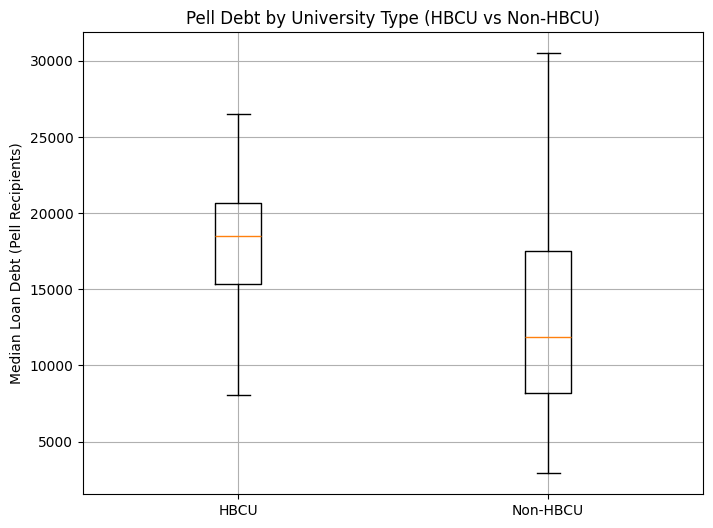

In [365]:
pell_debt_hbcu = df_r2.loc[df_r2['HBCU'] == 1, 'PELL_DEBT_MDN'].dropna()
pell_debt_non_hbcu = df_r2.loc[df_r2['HBCU'] == 0, 'PELL_DEBT_MDN'].dropna()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell recipients' median debt at HBCU vs. Non-HBCU institutions.
ax.boxplot([pell_debt_hbcu, pell_debt_non_hbcu], labels=['HBCU', 'Non-HBCU'])
ax.set_ylabel("Median Loan Debt (Pell Recipients)")
ax.set_title("Pell Debt by University Type (HBCU vs Non-HBCU)")
ax.grid(True)
plt.show()


-------------------------------
## 4.2 Statistical Test (t-test)
-------------------------------

In [366]:
tstat_pell, pvalue_pell = stats.ttest_ind(pell_debt_hbcu, pell_debt_non_hbcu, equal_var=False)

print("\n========================================================")
print("T-test: PELL_DEBT_MDN (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic = {tstat_pell:.3f}")
print(f"P-value     = {pvalue_pell:.3f}")


T-test: PELL_DEBT_MDN (HBCU vs. Non-HBCU)
T-statistic = 9.860
P-value     = 0.000


-------------------------------
## 4.3 Regression Analysis: PELL_DEBT_MDN ~ HBCU
-------------------------------

In [367]:
model_pell = smf.ols("PELL_DEBT_MDN ~ HBCU", data=df_r2).fit()

print("\n========================================================")
print("OLS Regression: PELL_DEBT_MDN ~ HBCU")
print("========================================================")
print(model_pell.summary())


OLS Regression: PELL_DEBT_MDN ~ HBCU
                            OLS Regression Results                            
Dep. Variable:          PELL_DEBT_MDN   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     55.23
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.36e-13
Time:                        21:46:03   Log-Likelihood:                -33262.
No. Observations:                3305   AIC:                         6.653e+04
Df Residuals:                    3303   BIC:                         6.654e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.

# 5. RESEARCH QUESTION 3

Research Question 3:
Is there a relationship between loan default rate / loan repayment rate 
and the amount borrowed (Pell debt), and does this relationship differ 
by HBCU status?

We'll use scatter plots to visualize, and then OLS regressions:
1. Default_Rate ~ PELL_DEBT_MDN + HBCU
2. Repayment_Rate ~ PELL_DEBT_MDN + HBCU

In [368]:
df_r3 = df_r3[['HBCU', 'INSTNM', 'Default_Rate', 'Repayment_Rate', 
               'PELL_DEBT_MDN', 'NOPELL_DEBT_MDN']]

-------------------------------
## 5.1 Visualizations of Pell Debt vs. Default Rate/Repayment Rate between HBCU and non-HBCU
-------------------------------

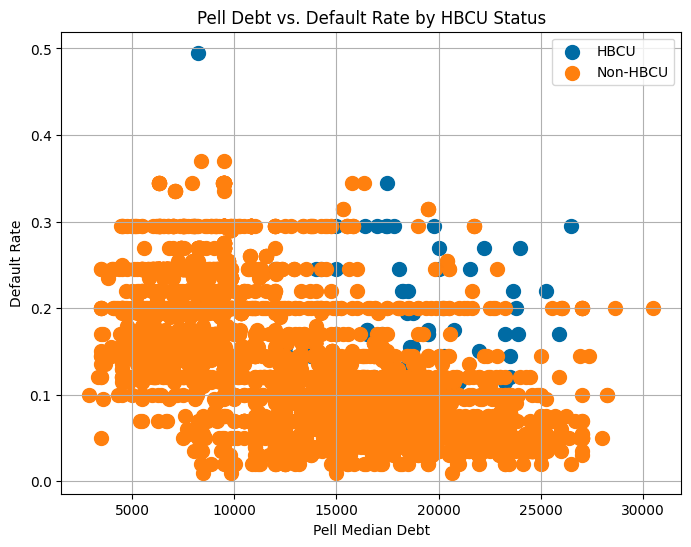

In [369]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This scatter plot shows Pell median debt (x-axis) versus Pell default rate (y-axis), colored by HBCU status.
hbcu_data = df_r3[df_r3['HBCU'] == 1]
non_hbcu_data = df_r3[df_r3['HBCU'] == 0]

# HBCU points
ax.scatter( hbcu_data['PELL_DEBT_MDN'],hbcu_data['Default_Rate'],label='HBCU',s=100
)

# Non-HBCU points
ax.scatter(non_hbcu_data['PELL_DEBT_MDN'],non_hbcu_data['Default_Rate'],label='Non-HBCU',s=100
)

ax.set_title("Pell Debt vs. Default Rate by HBCU Status")
ax.set_xlabel("Pell Median Debt")
ax.set_ylabel("Default Rate")
ax.legend()
ax.grid(True)
plt.show()

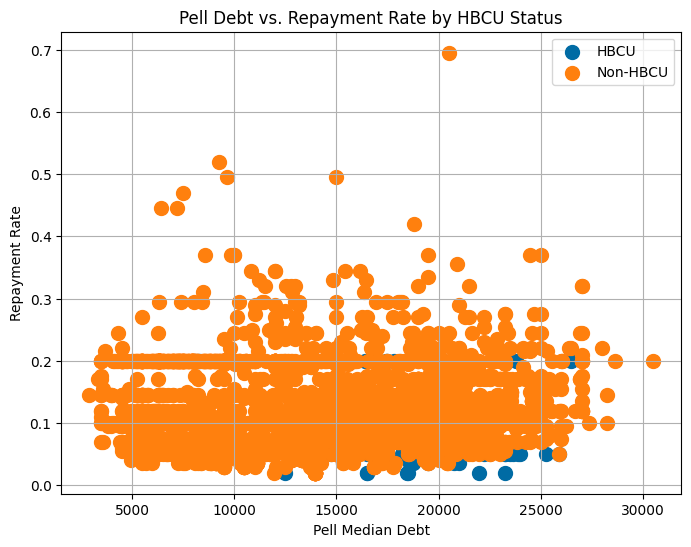

In [370]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This scatter plot shows Pell median debt (x-axis) versus Pell repayment rate (y-axis), colored by HBCU status.

# HBCU points
ax.scatter(hbcu_data['PELL_DEBT_MDN'],hbcu_data['Repayment_Rate'],label='HBCU',s=100)

# Non-HBCU points
ax.scatter(non_hbcu_data['PELL_DEBT_MDN'],non_hbcu_data['Repayment_Rate'],label='Non-HBCU',s=100)

ax.set_title("Pell Debt vs. Repayment Rate by HBCU Status")
ax.set_xlabel("Pell Median Debt")
ax.set_ylabel("Repayment Rate")
ax.legend()
ax.grid(True)
plt.show()

-------------------------------
## 5.2 Regression Analyses
-------------------------------

In [371]:
# Regression for Default Rate predicted by Pell Debt and HBCU
model_default = smf.ols('Default_Rate ~ PELL_DEBT_MDN + HBCU', data=df_r3).fit()

# Regression for Repayment Rate predicted by Pell Debt and HBCU
model_repayment = smf.ols('Repayment_Rate ~ PELL_DEBT_MDN + HBCU', data=df_r3).fit()

print("\n========================================================")
print("OLS Regression: Default_Rate ~ PELL_DEBT_MDN + HBCU")
print("========================================================")
print(model_default.summary())

print("\n========================================================")
print("OLS Regression: Repayment_Rate ~ PELL_DEBT_MDN + HBCU")
print("========================================================")
print(model_repayment.summary())


OLS Regression: Default_Rate ~ PELL_DEBT_MDN + HBCU
                            OLS Regression Results                            
Dep. Variable:           Default_Rate   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     978.0
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:46:03   Log-Likelihood:                 4455.0
No. Observations:                3305   AIC:                            -8904.
Df Residuals:                    3302   BIC:                            -8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# 6. CONCLUSIONS

Summary of Findings:

1. Default & Repayment Rates (RQ1):
   - 

2. Median Debt (RQ2):
   - 

3. Relation between Debt & Default/Repayment (RQ3):
   - 